In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Depth Estimation <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/dinov2/blob/main/notebooks/depth_estimation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

INSTALL = False # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

## Utilities

In [5]:
!git clone https://github.com/facebookresearch/dinov2.git

Cloning into 'dinov2'...
remote: Enumerating objects: 485, done.
remote: Total 485 (delta 0), reused 0 (delta 0), pack-reused 485 (from 1)
Receiving objects: 100% (485/485), 1.11 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
REPO_PATH = "/content/dinov2"  # مسیر محلی پروژه


In [4]:
!pip show dinov2


In [14]:
sys.path.append('/content/dinov2/eval/depth/models')


In [6]:
# REPO_PATH = "/content/drive/MyDrive/path_to_dinov2"
REPO_PATH = "/content/dinov2"

sys.path.append(REPO_PATH)


In [7]:
import os
print(os.listdir(REPO_PATH))


['pyproject.toml', 'CODE_OF_CONDUCT.md', 'requirements.txt', '.github', 'setup.cfg', 'CONTRIBUTING.md', 'conda.yaml', 'conda-extras.yaml', '.gitignore', 'LICENSE', 'requirements-dev.txt', 'hubconf.py', '.git', 'README.md', 'scripts', 'dinov2', 'requirements-extras.txt', 'setup.py', 'MODEL_CARD.md', 'notebooks']


In [23]:
import torch
print(torch.__version__)  # نسخه PyTorch
print(torch.version.cuda)  # نسخه CUDA



2.5.1+cu121
12.1


In [10]:
pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu121/torch2.5/index.html


Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.5/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 25.6 MB/s eta 0:00:00
  Created wheel for mmcv-full: filename=mmcv_full-1.7.2-cp310-cp310-linux_x86_64.whl size=32414482 sha256=30873a594b277430afbde5f9302bbc030559637fd410383bfb8584c9e2a33277
  Stored in directory: /root/.cache/pip/wheels/4e/10/0a/78fbabe3d28cc25866432d4ecd6c9b124b8f0a6f546974bb7e
Successfully built mmcv-full


In [11]:
import mmcv
print(mmcv.__version__)


1.7.2


/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [17]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F

from dinov2.eval.depth.models import build_depther
from dinov2.eval.depth.models import builder

class CenterPadding(torch.nn.Module):
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = F.pad(x, pads)
        return output


def create_depther(cfg, backbone_model, backbone_size, head_type):
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg=train_cfg, test_cfg=test_cfg)

    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n=cfg.model.backbone.out_indices,
        reshape=True,
        return_class_token=cfg.model.backbone.output_cls_token,
        norm=cfg.model.backbone.final_norm,
    )

    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    return depther

## Load pretrained backbone

In [92]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:06<00:00, 195MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


## Load pretrained depth head

In [93]:
import urllib

import mmcv
from mmcv.runner import load_checkpoint


def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()


HEAD_DATASET = "nyu" # in ("nyu", "kitti")
HEAD_TYPE = "dpt" # in ("linear", "linear4", "dpt")


DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format=".py")

model = create_depther(
    cfg,
    backbone_model=backbone_model,
    backbone_size=BACKBONE_SIZE,
    head_type=HEAD_TYPE,
)

load_checkpoint(model, head_checkpoint_url, map_location="cpu")
model.eval()
model.cuda()

load checkpoint from http path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_nyu_dpt_head.pth


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_nyu_dpt_head.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_nyu_dpt_head.pth
100%|██████████| 391M/391M [00:17<00:00, 23.6MB/s]


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

## Load sample image

In [90]:
pip install imageio


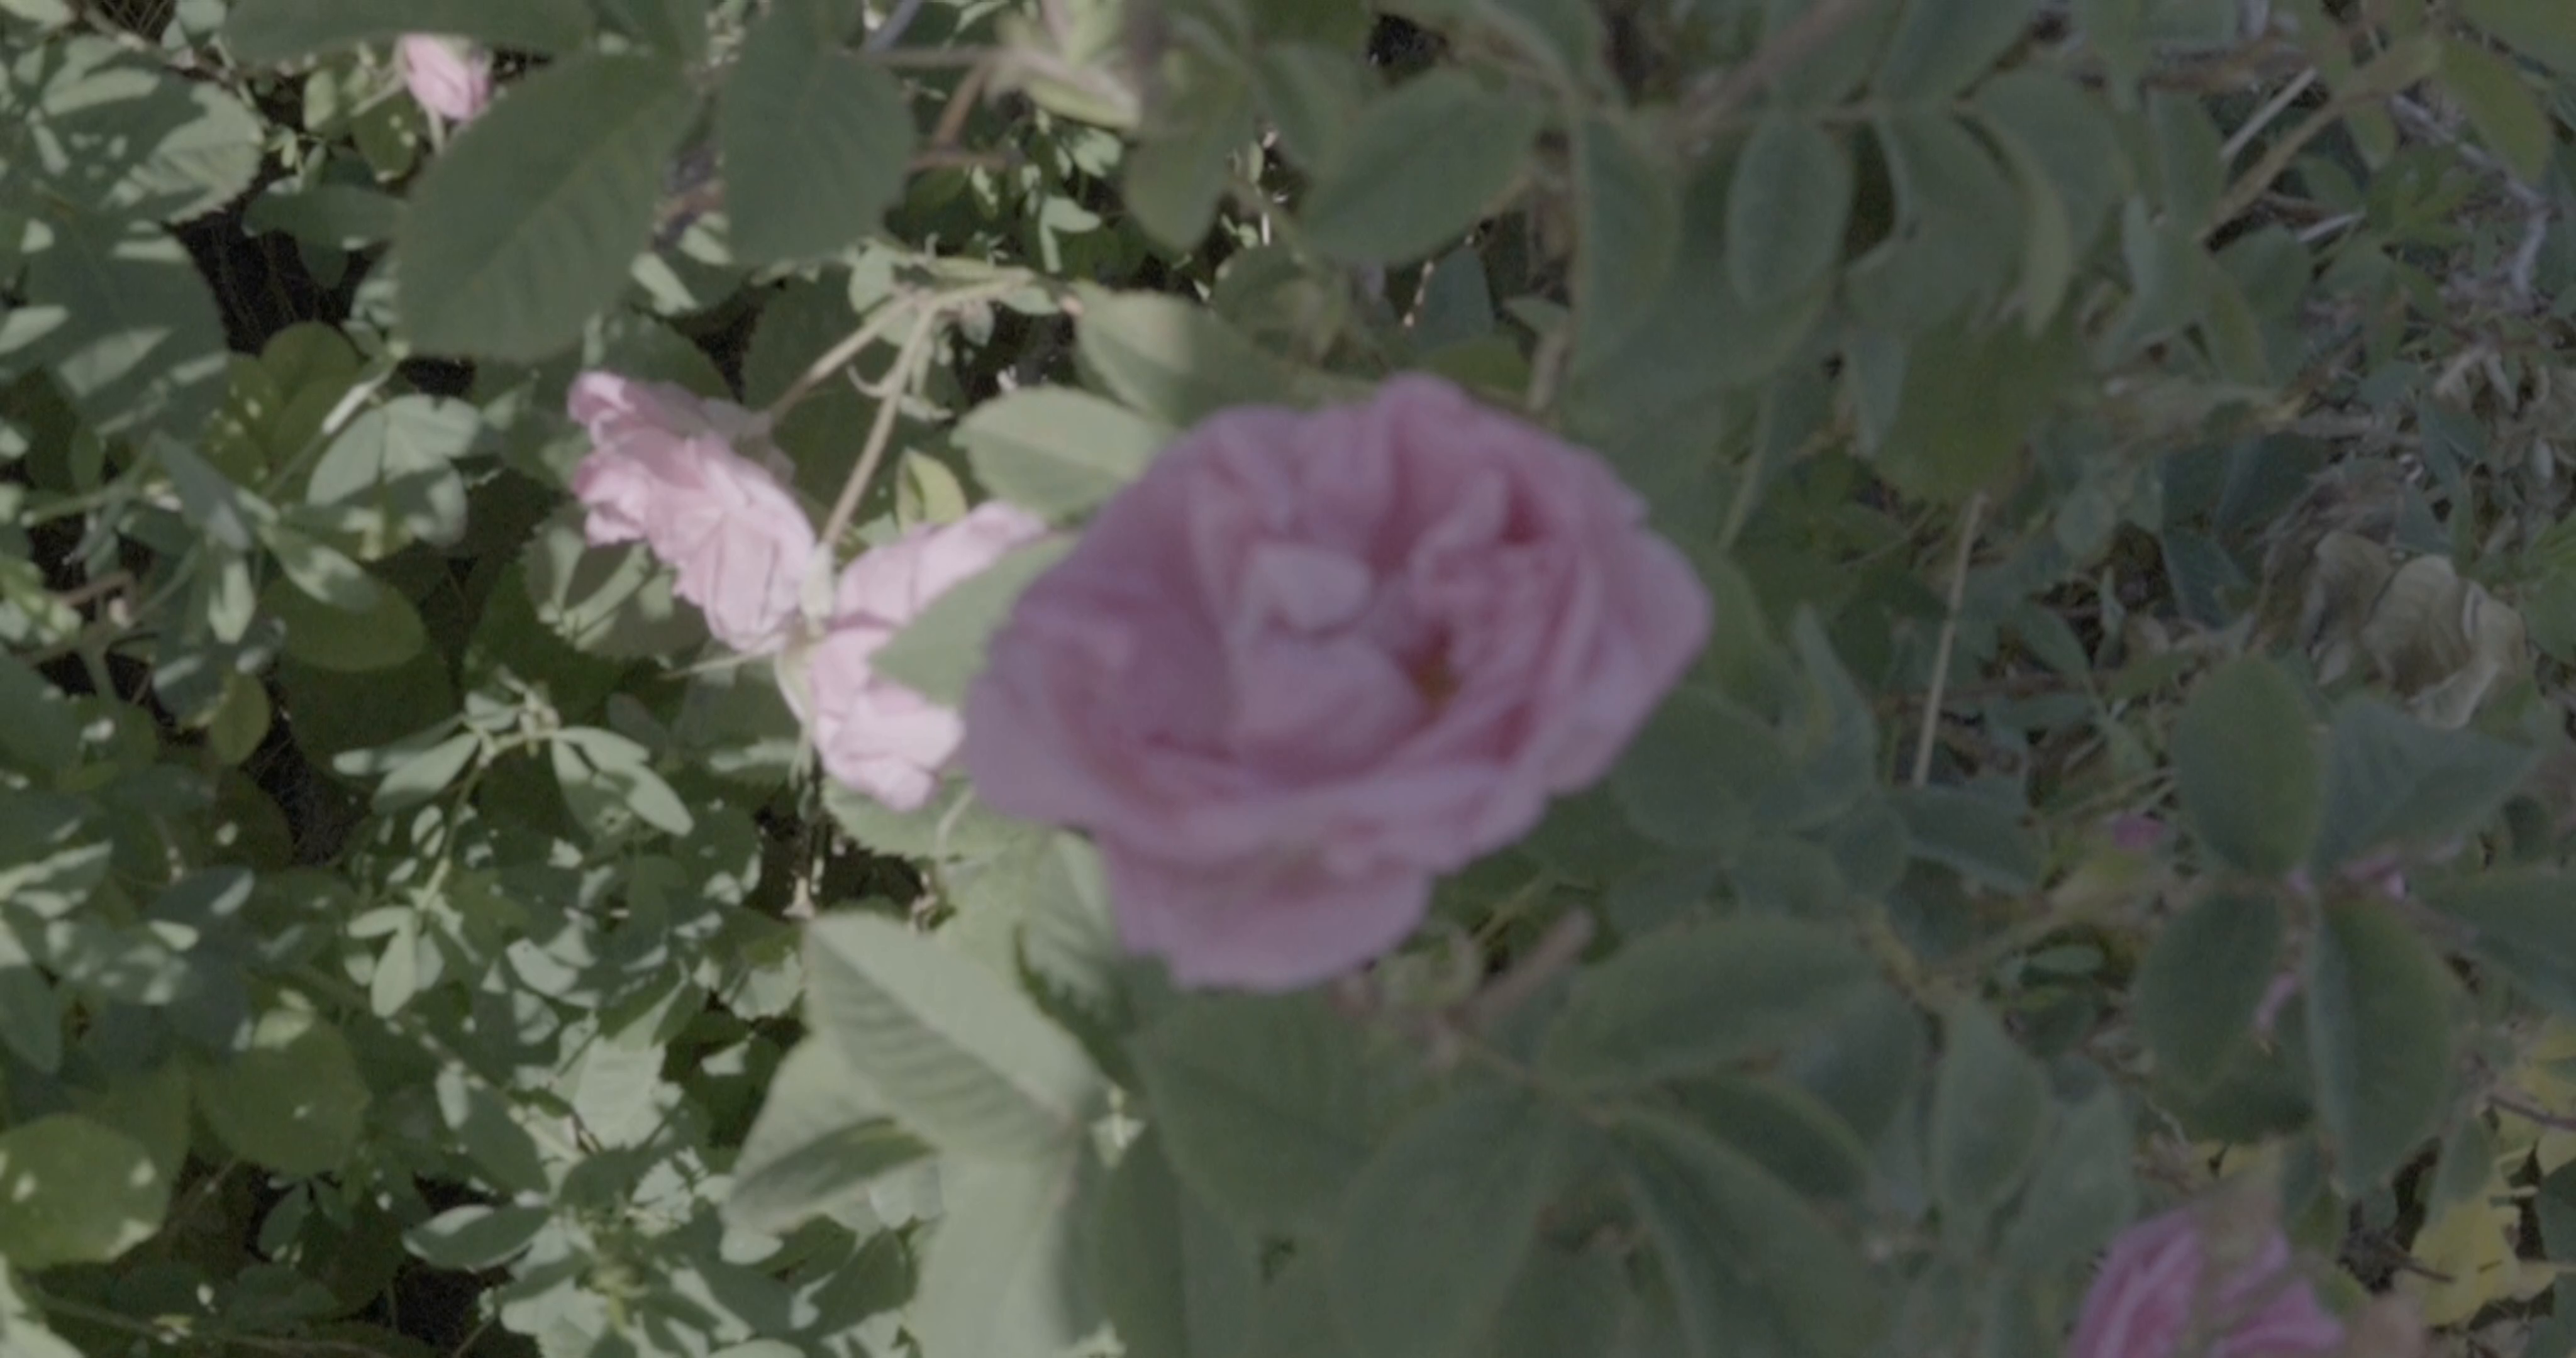

In [ ]:
import imageio
from PIL import Image
from IPython.display import display

# مسیر ویدیو
VIDEO_PATH = "/content/Untitled Folder 1/Untitled4.mp4"  # مسیر فایل ویدیویی

# تابعی برای نمایش ویدیو از فایل
def load_video_from_path(path: str):
    # بارگذاری ویدیو با استفاده از imageio
    video = imageio.get_reader(path)

    for frame in video:
        # تبدیل هر فریم به تصویر RGB
        image = Image.fromarray(frame)

        # نمایش فریم
        display(image)

        # برای ایجاد فاصله زمانی بین فریم‌ها، می‌توانید از `time.sleep` استفاده کنید
        # برای مثال:
         import time
         time.sleep(0.1)  # برای نمایش هر فریم به مدت 30 میلی‌ثانیه

# بارگذاری و نمایش ویدیو از مسیر
load_video_from_path(VIDEO_PATH)


In [100]:
from PIL import Image
import os
IMAGE_PATH = "/content/Untitled Folder/DSC01548.jpg"

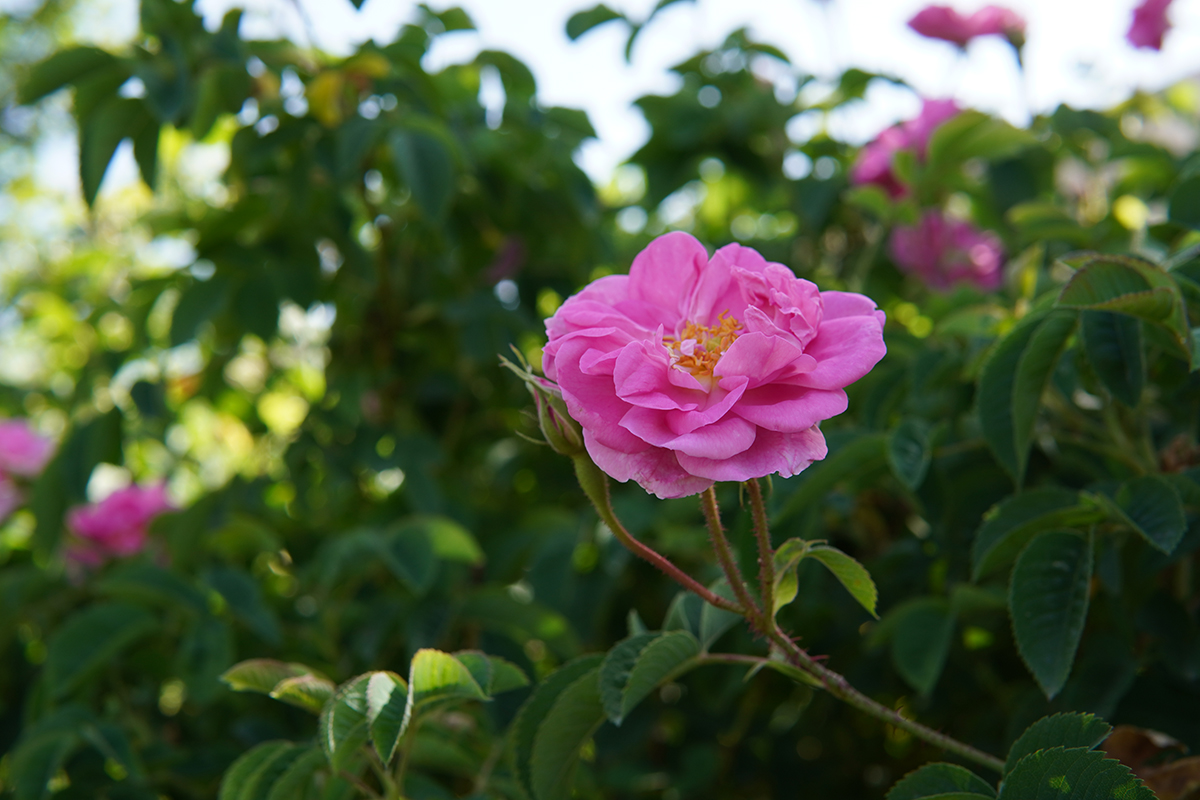

In [101]:


def load_image_from_path(path: str) -> Image:
    return Image.open(path).convert("RGB")

# بارگذاری و نمایش تصویر
image = load_image_from_path(IMAGE_PATH)
display(image)

In [45]:
# import urllib

# from PIL import Image


# def load_image_from_url(url: str) -> Image:
#     with urllib.request.urlopen(url) as f:
#         return Image.open(f).convert("RGB")


# EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"


# image = load_image_from_url(EXAMPLE_IMAGE_URL)
# display(image)

In [46]:
# image()

## Estimate depth on sample image

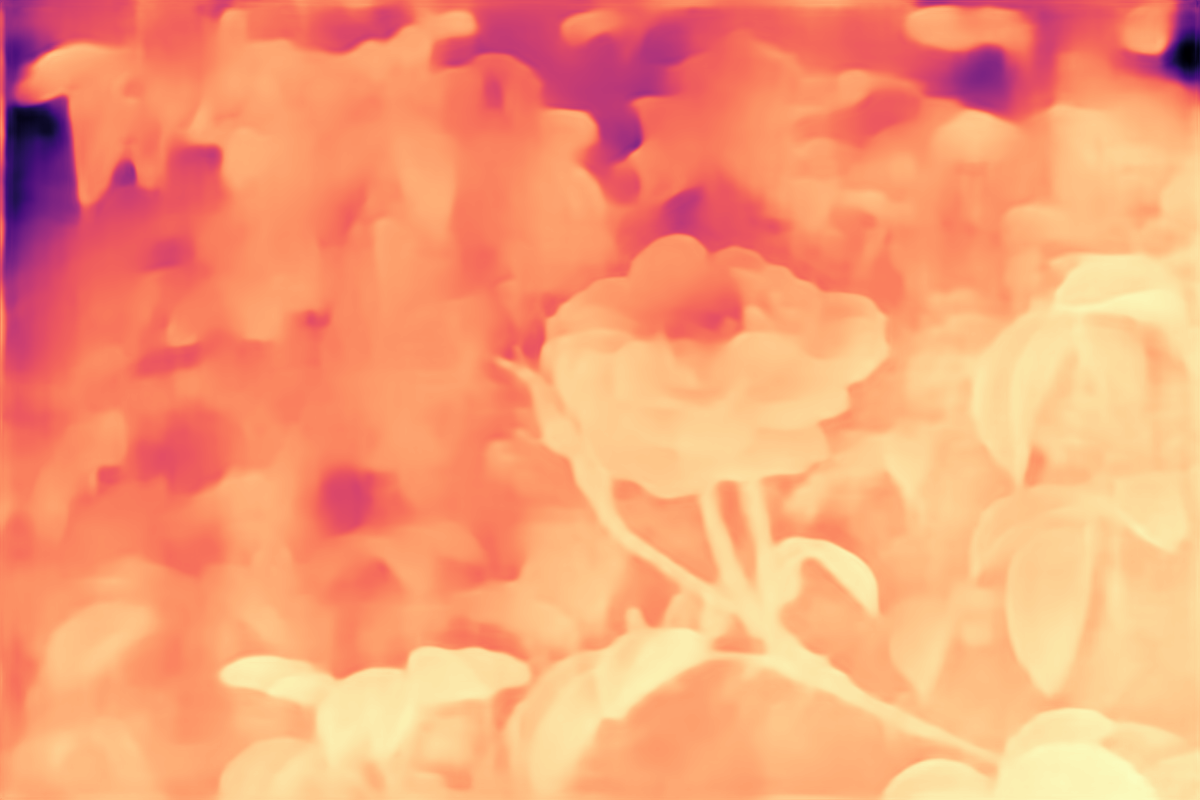

In [102]:
import matplotlib
from torchvision import transforms


def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        lambda x: 255.0 * x[:3], # Discard alpha component and scale by 255
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)


transform = make_depth_transform()

scale_factor = 1
rescaled_image = image.resize((scale_factor * image.width, scale_factor * image.height))
transformed_image = transform(rescaled_image)
batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

with torch.inference_mode():
    result = model.whole_inference(batch, img_meta=None, rescale=True)

depth_image = render_depth(result.squeeze().cpu())
display(depth_image)